In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
%run ./initialize.ipynb

Imported function `get_value_data(files, columns)` -> dataframe of values
Imported function `get_value_data(files, columns)` -> dataframe of returns
Imported function `initialize_data()` -> tuple of value and returns data
Imported class `Arbitrage(data : pd.DataFrame)` with methods `show_plot()`, `get_test_results()`


In [3]:
data = initialize_data()
df = data.get_ffill_data()
returns = data.get_true_return().dropna()
returns.head()

,us_agg,jpy,global_agg,gb,em_agg,ger,euro_agg,us
Date,,,,,,,,
2000-11-08,0.000624,-0.00005,-0.002368,0.000037,-0.005770,0.00010,-0.000192,-0.00011
2000-11-09,0.001960,-0.00010,0.002085,-0.000163,0.000349,-0.00021,0.000474,-0.00030
2000-11-10,0.000122,0.00004,0.000937,-0.000228,0.005363,-0.00009,0.000713,-0.00042
2000-11-13,0.002067,-0.00028,0.001797,-0.000358,0.003666,-0.00034,0.003032,-0.00017
2000-11-14,0.000787,0.00006,-0.001735,0.000177,0.002980,0.00002,-0.000744,-0.00011


In [45]:
total_return_df = df[['us_agg', 'global_agg', 'em_agg', 'euro_agg']]
yield_df = df[['jpy', 'gb', 'ger', 'us']]

## Methods to determine periods of high volatility.
- Look back 2 years, rank the rolling volatilities, and check whether we are in a 90th percentile or higher

In [36]:
def get_rolling_volatilities(data, rolling_period = 20):
    return data.rolling(rolling_period).std().dropna()

def rank_volatilities(volatility_data):
    from scipy.stats import percentileofscore
    percentiles = volatility_data.apply(lambda x: percentileofscore(volatility_data, x))
    return percentiles

def high_volatility_market(volatility_data):
    ranks = rank_volatilities(volatility_data)
    return 1 if ranks[-1] > 90 else 0    

In [37]:
lookback = 300
high_vol_df = get_rolling_volatilities(total_return_df).rolling(lookback).apply(high_volatility_market).dropna()

<Axes: >

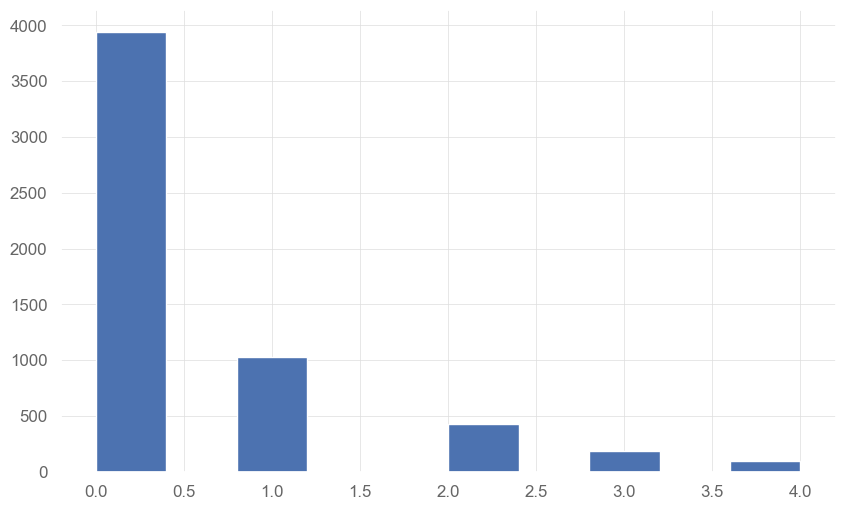

In [38]:
# notice whether high vol markets affect all markets simultaneously
high_vol_df.sum(axis = 1).hist()

In [83]:
# find points where 3 or 4 of the markets are in high volatility

highlight_dates = high_vol_df.sum(axis = 1)[high_vol_df.sum(axis = 1) >= 3].index
highlight_dates

DatetimeIndex(['2002-06-24', '2002-06-25', '2002-06-26', '2002-06-27',
               '2002-11-11', '2003-05-08', '2003-05-09', '2003-05-12',
               '2003-05-13', '2003-05-14',
               ...
               '2022-10-05', '2022-10-06', '2022-10-07', '2022-11-23',
               '2022-11-24', '2022-11-25', '2022-11-28', '2022-11-29',
               '2022-11-30', '2022-12-01'],
              dtype='datetime64[ns]', name='Date', length=286, freq=None)

In [84]:
def equity_curve_data(asset):
    if isinstance(asset, pd.DataFrame):
        asset = asset.apply(to_stationary, axis = 0)
        insert_row = pd.Series([0] * len(asset.columns), index = asset.columns)
        asset.iloc[0] = insert_row
    
    elif max(asset) > 0.5:
        asset = to_stationary(asset).dropna()
    
    plot_values = (asset + 1).cumprod()
    return plot_values

In [87]:
def extract_start_end_dates(timestamp_list, max_gap_days=252):
    start_dates = []
    end_dates = []

    current_group_start = current_group_end = timestamp_list[0]

    for i in range(1, len(timestamp_list)):
        # Check if the current timestamp is within max_gap_days of the last timestamp in the group
        if (timestamp_list[i] - current_group_end).days <= max_gap_days:
            # Update the end date of the current group
            current_group_end = timestamp_list[i]
        else:
            # Add the start and end dates of the completed group
            start_dates.append(current_group_start)
            end_dates.append(current_group_end)

            # Start a new group
            current_group_start = current_group_end = timestamp_list[i]

    # Add the start and end dates of the last group
    start_dates.append(current_group_start)
    end_dates.append(current_group_end)

    res = [(s, e) for s, e in zip(start_dates, end_dates)]
    return res

groups = extract_start_end_dates(highlight_dates)

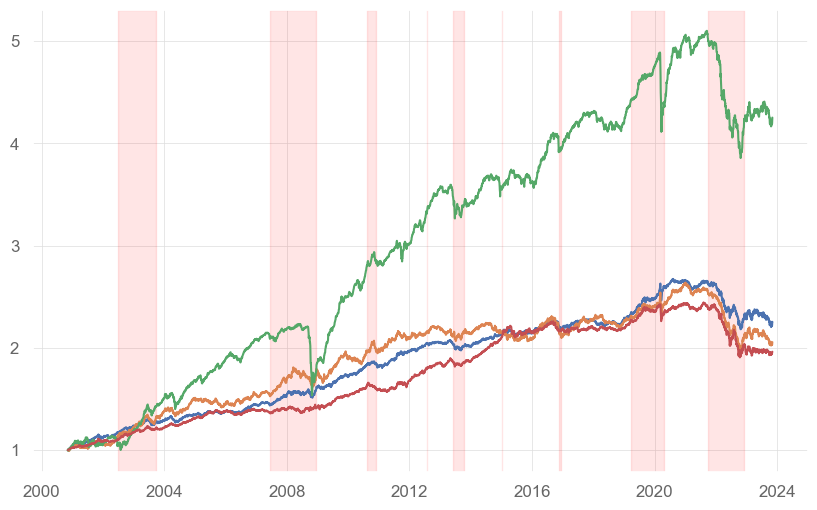

In [103]:
# Highlight the specified dates and extend the shading to cover the weekend
for s, e in groups:
    plt.axvspan(s, e, color='red', alpha=0.1)

d = equity_curve_data(total_return_df)
plt.plot(d.index, d.values)

# Customize the plot
plt.grid(True)

In [120]:
possible_colors = ['red', 'orange', 'blue', 'green', 'yellow',  'purple', 'pink']

def plot_volatile(data, start_vol, end_vol, lf):
    colors = possible_colors[:len(data.columns)]
    duration = pd.Timedelta(days = lf)
    vol_equity = equity_curve_data(data.loc[start_vol : end_vol])
    for i, column in enumerate(vol_equity.columns):
        plt.plot(vol_equity.index, vol_equity.loc[:, column], color = colors[i], label = column)
    plt.axvspan(start_vol, end_vol, color='red', alpha=0.2)
    
    post_vol_equity = equity_curve_data(data.loc[end_vol : end_vol + duration])
    for i, column in enumerate(post_vol_equity.columns):
        plt.plot(post_vol_equity.index, post_vol_equity.loc[:, column], color = colors[i])

    plt.axvline(end_vol, linewidth = 4, color = 'black')
    plt.legend()

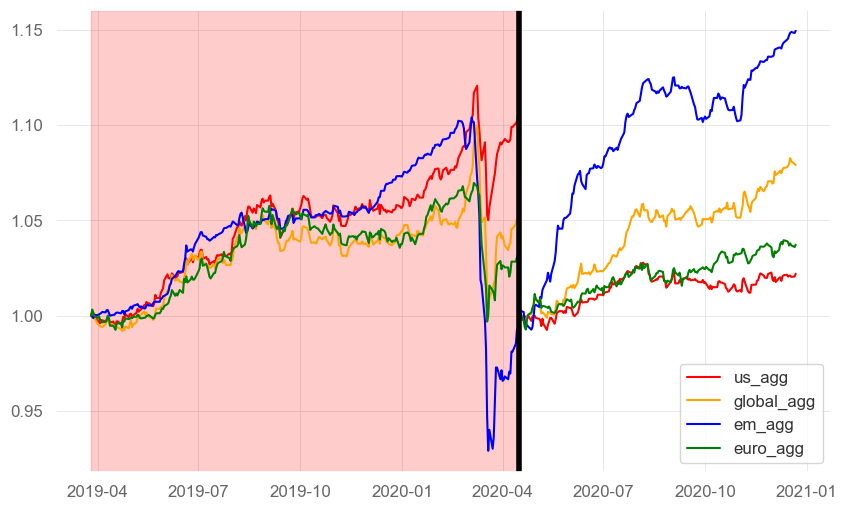

In [121]:
covid_start, covid_end = groups[-2]
plot_volatile(total_return_df, covid_start, covid_end, 250)

## Build rough strategy
Idea: If we are in a period of high volatility (defined as above). Once we exit the period of volatility we can assume that the next period will have lower volatilities. During these times, we will assume arbitrage opportunnities exist.

- Step 1: Look for 3 days in a row of high volatility signal
- Step 2: Look back 1.5 years, ignoring high volatility times, and find optimal hedge ratio on the two assets
- Step 3: Trade the arbitrage for 2 weeks.

In [79]:
class Portfolio:
    
    def __init__(self, asset_returns, weights):
        
        self.weights = weights
        self.asset_returns = asset_returns
        self.returns = (self.weights * self.asset_returns).sum(axis = 1)
        
    def plot(self):
        (self.returns + 1).cumprod().plot()

In [80]:
class Test:
    
    def __init__(self, data):
        
        self.data = data.copy()
        self.asset_rtn = data.apply(to_stationary, axis = 0)
        
        ew = data.copy().applymap(lambda x : 1 / len(data.columns))
        self.ew_portfolio = Portfolio(self.asset_rtn, ew)
        
        self.positions = self.data.applymap(lambda x: 0)
        
        rolling_volatilities = get_rolling_volatilities(self.ew_portfolio.returns, 15).dropna()
        self.high_volatility = rolling_volatilities.rolling(252).apply(high_volatility_market).dropna()

    
    def __backtest__(self):
        
        def find_positions(volatile_flag):
            enter, exit = [], []
            stack = []
            current_period = 0
            for date, value in volatile_flag.items():
                previous_highvol = len(list(filter(lambda x : x == 1, stack)))
                current_period += 1
                if previous_highvol == 3 and value == 0:
                    enter.append(date)
                    current_period = 0
                elif len(enter) > len(exit) and value == 1:
                    exit.append(date)
                    current_period = 0
                elif len(enter) > len(exit) and current_period > 20:
                    exit.append(date)
                    current_period = 0

                if len(stack) == 3: stack.pop(0)
                stack.append(value)
                
            return [(ent, ex) for ent, ex in zip(enter, exit)]
    
        positions = find_positions(self.high_volatility)        
        length = 365
        alpha = 0.05
        for entrance, exit in positions:
            start, end = entrance - pd.Timedelta(days = length), entrance
            relevant = self.data.loc[start: end]
            arb = Arbitrage(relevant, method = 'ols')
            # if there isn't any cointegration over the past 3 months, just ignore this signal
            if arb.get_test_results()[1] > alpha:
                continue
            
            test_arb = self.data.loc[entrance: exit]
            x_test = test_arb.drop([arb.dependent], axis = 1)
            y_test = test_arb[arb.dependent]
            
            # go time step by time step - shorting / longing as needed
            current_index = 0
            while current_index < len(y_test):
                date = y_test.index[current_index]
                prediction = arb.model.predict(x_test.iloc[current_index])[0]
                true = y_test[current_index]
                deviation = true - prediction
                total_assets = len(x_test.iloc[current_index]) + 1
                
                # arbitrage
                if deviation > 0:
                    long_assets = total_assets - 1
                    pos = pd.Series([1 / long_assets / 3] * total_assets, index = self.data.columns)
                    pos.loc[arb.dependent] = -1 / 3
                    self.positions.loc[date] = pos
                
                elif deviation < 0:
                    short_assets = total_assets - 1
                    pos = pd.Series([-1 / short_assets / 3] * total_assets, index = self.data.columns)
                    pos.loc[arb.dependent] = 1 / 3
                    self.positions.loc[date] = pos
                
                current_index += 1
                    

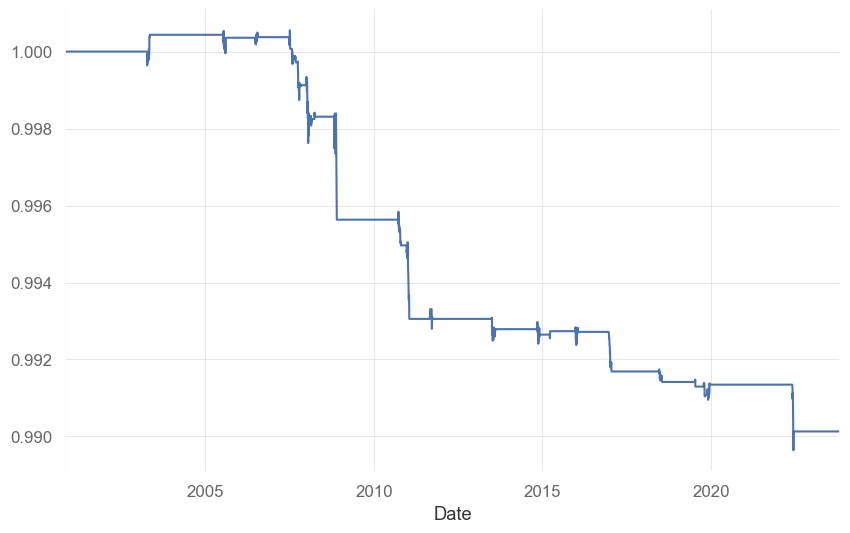

In [81]:
item = Test(yield_df)
item.__backtest__()
rtnz = returns[item.positions.columns]
Portfolio(rtnz, item.positions).plot()

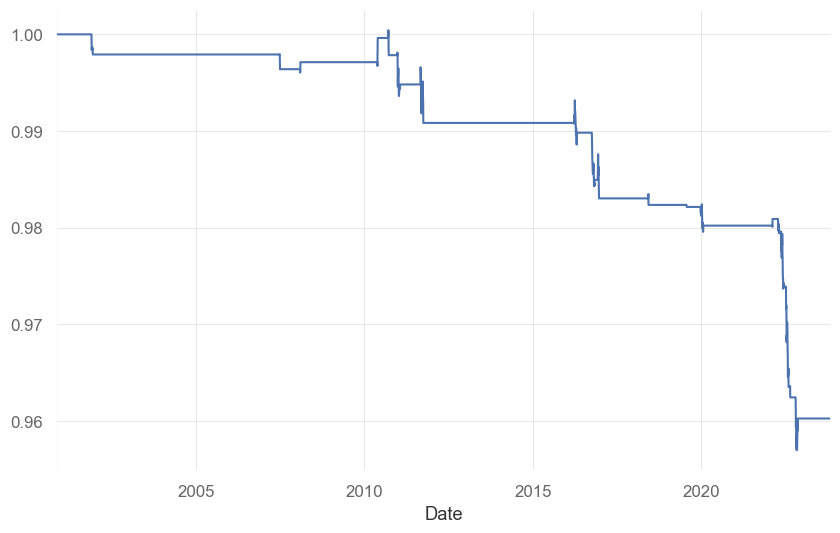

In [82]:
item = Test(total_return_df)
item.__backtest__()
rtnz = returns[item.positions.columns]
Portfolio(rtnz, item.positions).plot()